In [453]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# !pip install iminuit
from iminuit import Minuit

***Zihan Zhao, Shrihari Jhawar, Xinyue Liu, Haiwen Xu***

*Winter 2025 UCSD*

## Load Data....

In [454]:
start = time.time()

In [455]:
# dir = "/content/drive/My Drive/DSC291_WI25_Final/"
# dir = "drive/MyDrive/DSC291_WI25_Final/"

dir = "./"


detector_A = pd.read_csv(dir+'DetectorA.csv', sep=',', header=0, names=['Event_ID', 'CNN_Score', 'Energy'])
detector_B = pd.read_csv(dir+'DetectorB.csv', sep=',', header=0, names=['Event_ID', 'CNN_Score', 'Energy'])
detector_C = pd.read_csv(dir+'DetectorC.csv', sep=',', header=0, names=['Event_ID', 'CNN_Score', 'Energy'])
detector_Target = pd.read_csv(dir+'DetectorTarget.csv', sep=',', header=0, names=['EventID', 'CNN_Score', 'Energy'])

## variables and parameters:

In [456]:
# Iuput variables will be used later...

width = 3

A_peak = 1592
A_peak_lo = A_peak - width
A_peak_hi = A_peak + width
A_peak_arr = np.linspace(A_peak_lo, A_peak_hi, 10)

other1_peak = 1622
other1_peak_lo = other1_peak - width
other1_peak_hi = other1_peak + width

N_peak = 2039
N_peak_lo = N_peak - width
N_peak_hi = N_peak + width
sigma = 1
N_peak_arr = np.linspace(N_peak_lo, N_peak_hi, 10)

B_peak = 2103
B_peak_lo = B_peak - width
B_peak_hi = B_peak + width
B_peak_arr = np.linspace(B_peak_lo, B_peak_hi, 10)

other2_peak = 2614
other2_peak_lo = other2_peak - 2*width
other2_peak_hi = other2_peak + 2*width

lowE = 1000
highE = 3000

fine_bin_width = 1  # Finer bin width in ROIs
coarse_bin_width = 10  # Coarser bin width outside ROIs


rois = [(A_peak_lo, A_peak_hi),
        (other1_peak_lo, other1_peak_hi),
        (N_peak_lo, N_peak_hi),
        (B_peak_lo, B_peak_hi),
        (other2_peak_lo, other2_peak_hi)]
# rois = [(N_peak_lo, N_peak_hi)]



## Energy Spectrum

In [457]:
# Initialize bins with coarse bins before the first ROI
bins = np.arange(lowE, rois[0][0], coarse_bin_width)

# Loop through each ROI and add bins
for i, (roi_min, roi_max) in enumerate(rois):
    # Fine bins within the current ROI
    fine_bins = np.arange(roi_min, roi_max, fine_bin_width)
    bins = np.concatenate((bins, fine_bins))

    # Check if this is the last ROI or not
    if i < len(rois) - 1:
        next_roi_min = rois[i + 1][0]
    else:
        next_roi_min = highE

    # Coarse bins between the current ROI and the next one
    coarse_bins = np.arange(roi_max, next_roi_min, coarse_bin_width)
    bins = np.concatenate((bins, coarse_bins))

# Ensure the final bin reaches exactly highE
if bins[-1] < highE:
    bins = np.append(bins, highE)

# print("Bin centers:", bins)


# Calculate bin widths (difference between consecutive centers)
bin_widths = np.diff(bins)

# Calculate bin edges
bin_edges = np.concatenate((
    [bins[0] - bin_widths[0] / 2],  # First edge
    bins[:-1] + bin_widths / 2,     # Intermediate edges
    [bins[-1] + bin_widths[-1] / 2] # Last edge
))

print("Bin Edges:", bin_edges)





n_bins = bin_edges
# n_bins = 200
print('Number of Bins: ' + str(len(bins)))

counts_lo = 1e-1
counts_hi = 5000

Bin Edges: [ 995.  1005.  1015.  1025.  1035.  1045.  1055.  1065.  1075.  1085.
 1095.  1105.  1115.  1125.  1135.  1145.  1155.  1165.  1175.  1185.
 1195.  1205.  1215.  1225.  1235.  1245.  1255.  1265.  1275.  1285.
 1295.  1305.  1315.  1325.  1335.  1345.  1355.  1365.  1375.  1385.
 1395.  1405.  1415.  1425.  1435.  1445.  1455.  1465.  1475.  1485.
 1495.  1505.  1515.  1525.  1535.  1545.  1555.  1565.  1575.  1584.5
 1589.5 1590.5 1591.5 1592.5 1593.5 1594.5 1600.  1610.  1617.  1619.5
 1620.5 1621.5 1622.5 1623.5 1624.5 1630.  1640.  1650.  1660.  1670.
 1680.  1690.  1700.  1710.  1720.  1730.  1740.  1750.  1760.  1770.
 1780.  1790.  1800.  1810.  1820.  1830.  1840.  1850.  1860.  1870.
 1880.  1890.  1900.  1910.  1920.  1930.  1940.  1950.  1960.  1970.
 1980.  1990.  2000.  2010.  2020.  2030.  2035.5 2036.5 2037.5 2038.5
 2039.5 2040.5 2041.5 2047.  2057.  2067.  2077.  2087.  2096.  2100.5
 2101.5 2102.5 2103.5 2104.5 2105.5 2111.  2121.  2131.  2141.  2151.
 2161

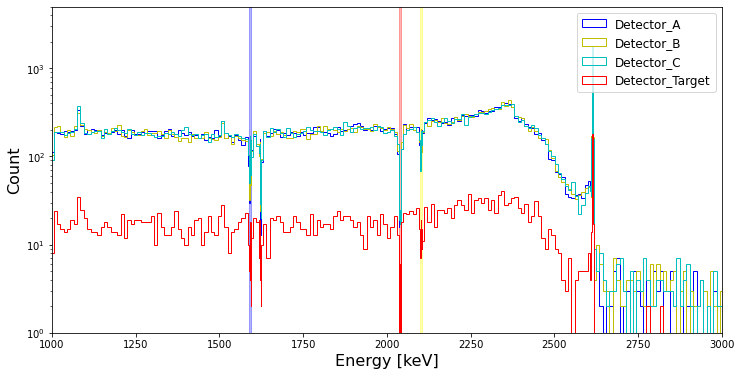

In [458]:
# Energies are in keV

E_A = detector_A['Energy']
E_B = detector_B['Energy']
E_C = detector_C['Energy']
E_T = detector_Target['Energy']

plt.figure(figsize=(12,6))
plt.hist(E_A, n_bins, histtype='step', stacked=True, fill=False, label='Detector_A', color='b')
plt.hist(E_B, n_bins, histtype='step', stacked=True, fill=False, label='Detector_B', color='y')
plt.hist(E_C, n_bins, histtype='step', stacked=True, fill=False, label='Detector_C', color='c')
plt.hist(E_T, n_bins, histtype='step', stacked=True, fill=False, label='Detector_Target', color='r')
plt.legend(fontsize=12)
plt.yscale('log')
plt.xlim(lowE,highE)
# plt.xlim(2600,2655)

plt.ylim(1e0,5e3)
plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('Count',fontsize=16)

plt.fill_between(A_peak_arr, counts_lo, counts_hi, color='blue', alpha=0.3)
plt.fill_between(B_peak_arr, counts_lo, counts_hi, color='yellow', alpha=0.3)
plt.fill_between(N_peak_arr, counts_lo, counts_hi, color='red', alpha=0.3)

plt.show()

## Identify SS signal from detectorA and MS background from detectorB and corresponding baselines

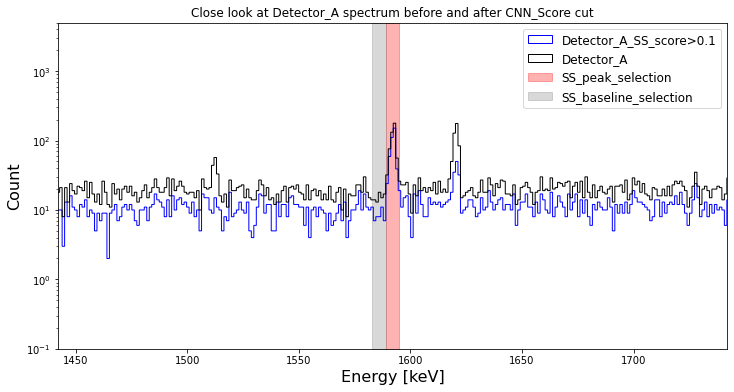

In [459]:
# apply 0.2 cutting threshold to the CNN_Score to Detector_A:
n_bins_peak = 2000
A_CNN_cut = detector_A['CNN_Score'] > 0.1
E_A = detector_A[A_CNN_cut]['Energy']

plt.figure(figsize=(12,6))
plt.hist(E_A, n_bins_peak, histtype='step', stacked=True, fill=False, label='Detector_A_SS_score>0.1', color='b')
plt.hist(detector_A['Energy'], n_bins_peak, histtype='step', stacked=True, fill=False, label='Detector_A', color='k')


plt.yscale('log')
plt.xlim(A_peak - 50*width,A_peak + 50*width)
plt.ylim(counts_lo,counts_hi)
plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Close look at Detector_A spectrum before and after CNN_Score cut')

plt.fill_between(np.linspace(A_peak-width,A_peak+width, 10), counts_lo, counts_hi, color='red', alpha=0.3, label='SS_peak_selection')
plt.fill_between(np.linspace(A_peak-3*width,A_peak-width, 10), counts_lo, counts_hi, color='grey', alpha=0.3, label='SS_baseline_selection')

plt.legend(fontsize=12)
plt.show()

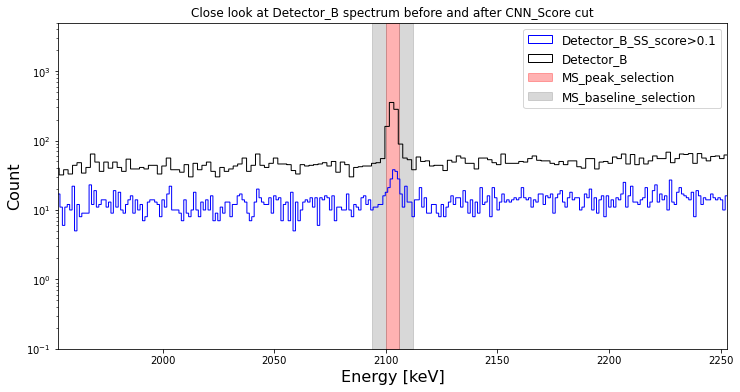

In [460]:
# apply 0.2 cutting threshold to the CNN_Score to Detector_A:
n_bins_peak = 2000
B_CNN_cut = detector_B['CNN_Score'] > 0.1
E_B = detector_B[B_CNN_cut]['Energy']

plt.figure(figsize=(12,6))
plt.hist(E_B, n_bins_peak, histtype='step', stacked=True, fill=False, label='Detector_B_SS_score>0.1', color='b')
plt.hist(detector_B['Energy'], n_bins_peak, histtype='step', stacked=True, fill=False, label='Detector_B', color='k')

plt.yscale('log')
plt.xlim(B_peak - 50*width,B_peak + 50*width)
plt.ylim(counts_lo,counts_hi)
plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Close look at Detector_B spectrum before and after CNN_Score cut')

plt.fill_between(np.linspace(B_peak-width,B_peak+width, 10), counts_lo, counts_hi, color='red', alpha=0.3, label='MS_peak_selection')
plt.fill_between(np.linspace(B_peak-3*width,B_peak-width, 10), counts_lo, counts_hi, color='grey', alpha=0.3, label='MS_baseline_selection')
plt.fill_between(np.linspace(B_peak+width,B_peak+3*width, 10), counts_lo, counts_hi, color='grey', alpha=0.3)

plt.legend(fontsize=12)

plt.show()

## Estimation of TPR and FPR from signal and backgound with the subtraction of baseline

In [461]:
def get_TPR(energy_data,CNN_data, peak_center, width, n_bins, threshold, plot):

  # Define cuts to the energy spectrum for both "SS Peak" and "SS Baseline"
  SS_selection = (energy_data >= peak_center - width) & (energy_data <= peak_center + width)
  SS_baseline_selection = (energy_data >= peak_center - 3*width) & (energy_data <= peak_center - width)
  # MS_baseline_selection = (energy_data >= peak_center + width) & (energy_data <= peak_center + 3*width)


  # Apply cuts to both [Energy] and [CNN_Score]

  SS_energy = energy_data[SS_selection]
  SS_baseline_energy = energy_data[SS_baseline_selection]
  SS_CNN = CNN_data[SS_selection]
  SS_baseline_CNN = CNN_data[SS_baseline_selection]

  # retrieve cutting threshold for [CNN_Score]
  CNN_Score_threshold = threshold

  # Plot the [CNN_Score] histogram if you want:)
  # return the
  if(plot):
    SS_CNNhist, SS_CNNedges, _= plt.hist(SS_CNN, 50, range=(0,1), histtype='step', stacked=True, fill=False, label='SS')
    SS_baseline_CNNhist, SS_baseline_CNNedges, _ = plt.hist(SS_baseline_CNN, 50, range=(0,1), histtype='step', stacked=True, fill=False, label='SS_baseline')
    SS_sub_baseline_hist = SS_CNNhist - SS_baseline_CNNhist
    cut_index = np.where(SS_CNNedges>= CNN_Score_threshold)[0][0]
    #denom = np.sum(SS_sub_baseline_hist) if not is_signal else
    TPR = np.sum(SS_sub_baseline_hist[cut_index:-1])/np.sum(SS_sub_baseline_hist)

    plt.hist(SS_CNNedges[:-1], 50, weights=SS_sub_baseline_hist,histtype='step', stacked=True, fill=False, label='SS_sub_baseline')
    plt.title('TPR = ' + f'{TPR:.3f}' + ';  ' +'CNN_Score_threshold = ' + f'{CNN_Score_threshold:.1f}')
    plt.legend()
    plt.show()


  else:
    SS_CNNhist, SS_CNNedges= np.histogram(SS_CNN, n_bins, range=(0,1))
    SS_baseline_CNNhist, SS_baseline_CNNedges = np.histogram(SS_baseline_CNN, n_bins, range=(0,1))
    SS_sub_baseline_hist = SS_CNNhist - SS_baseline_CNNhist
    cut_index = np.where(SS_CNNedges>= CNN_Score_threshold)[0][0]
    TPR = np.sum(SS_sub_baseline_hist[cut_index:-1])/np.sum(SS_sub_baseline_hist)
  return np.round(TPR,3)


def get_FPR(energy_data, CNN_data, peak_center, width, n_bins, threshold, plot):

    MS_selection = (energy_data >= peak_center - width) & (energy_data <= peak_center + width)
    MS_basleline_Lselection = (energy_data >= peak_center - 3*width) & (energy_data <= peak_center - width)
    MS_baseline_Rselection = (energy_data >= peak_center + width) & (energy_data <= peak_center + 3*width)

    MS_CNN = CNN_data[MS_selection]
    MS_baseline_CNN = CNN_data[(MS_basleline_Lselection) | (MS_baseline_Rselection)]
    # baseline_CNN = np.concatenate([baseline_low_CNN, baseline_high_CNN])

    # cut_index = baseline_CNN >= threshold
    # FPR = np.sum(cut_index) / len(baseline_CNN)

    CNN_Score_threshold = threshold

    # Plot CNN Score distribution for background if requested

    if(plot):
      MS_CNNhist, MS_CNNedges, _= plt.hist(MS_CNN, 50, range=(0,1), histtype='step', stacked=True, fill=False, label='MS')
      MS_baseline_CNNhist, MS_baseline_CNNedges, _ = plt.hist(MS_baseline_CNN, 50, range=(0,1), histtype='step', stacked=True, fill=False, label='MS_baseline')
      MS_sub_baseline_hist = MS_CNNhist - 0.5*MS_baseline_CNNhist
      cut_index = np.where(MS_CNNedges>= CNN_Score_threshold)[0][0]
      FPR = np.sum(MS_sub_baseline_hist[cut_index:-1])/np.sum(MS_sub_baseline_hist)

      plt.hist(MS_CNNedges[:-1], 50, weights=MS_sub_baseline_hist,histtype='step', stacked=True, fill=False, label='MS_sub_baseline')
      plt.title('FPR = ' + f'{FPR:.3f}' + ';  ' +'CNN_Score_threshold = ' + f'{CNN_Score_threshold:.1f}')
      plt.legend()
      plt.show()
    else:
      MS_CNNhist, MS_CNNedges= np.histogram(MS_CNN, n_bins, range=(0,1))
      MS_baseline_CNNhist, MS_baseline_CNNedges = np.histogram(MS_baseline_CNN, n_bins, range=(0,1))
      MS_sub_baseline_hist = MS_CNNhist - 0.5*MS_baseline_CNNhist
      cut_index = np.where(MS_CNNedges>= CNN_Score_threshold)[0][0]
      FPR = np.sum(MS_sub_baseline_hist[cut_index:-1])/np.sum(MS_sub_baseline_hist)
    return np.round(FPR,3)


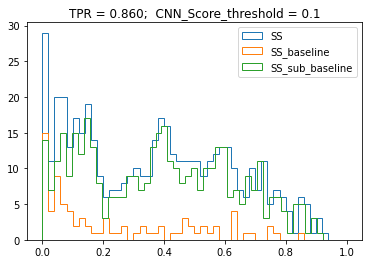

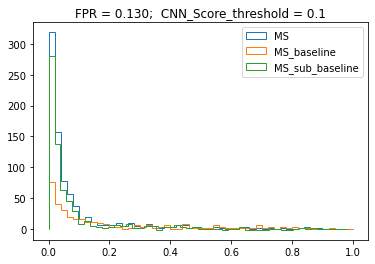

In [462]:
eyeballed_threshold = 0.1
tpr = get_TPR(detector_A['Energy'],detector_A['CNN_Score'], A_peak, width, 50, eyeballed_threshold,True)
fpr = get_FPR(detector_B['Energy'],detector_B['CNN_Score'], B_peak, width, 50, eyeballed_threshold,True)

## Determine a CNN_Score cutting threshold based on the estimation of F-Score

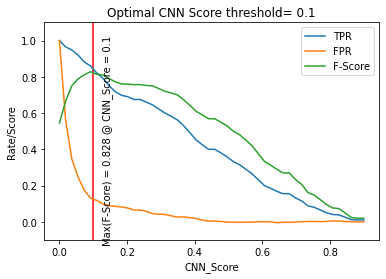

In [463]:
# plot the tpr for a range of cuts
tpr_arr = []
fpr_arr = []

threshold_arr = np.linspace(0.0, 0.9, 50)
for cut in threshold_arr:
  # tpr = calc_tpr(detector_A[A_peak_cut], cut)
  tpr = get_TPR(detector_A['Energy'],detector_A['CNN_Score'], A_peak, width, 50, cut,False)
  tpr_arr.append(tpr)
  fpr = get_FPR(detector_B['Energy'],detector_B['CNN_Score'], B_peak, width, 50, cut,False)
  fpr_arr.append(fpr)

P = detector_A['CNN_Score'][(detector_A['Energy'] >= A_peak_lo)&(detector_A['Energy'] <= A_peak_hi)].size
N = detector_B['CNN_Score'][(detector_B['Energy'] >= B_peak_lo)&(detector_B['Energy'] <= B_peak_hi)].size

precision = np.array(tpr_arr)*P/(np.array(tpr_arr)*P+np.array(fpr_arr)*N)

f_score = 2*precision*np.array(tpr_arr)/(precision + np.array(tpr_arr))

CNN_threshold = np.round(threshold_arr[np.where(f_score == f_score.max())[0][0]],1)


plt.plot(threshold_arr, tpr_arr,label='TPR')
plt.plot(threshold_arr, fpr_arr,label='FPR')
plt.plot(threshold_arr, f_score,label='F-Score')
# plt.plot(threshold_arr, TPRsubFPR,label='TPR - FPR')

plt.text(CNN_threshold+0.025,0.45
        ,('Max(F-Score) = '+str(np.round(f_score.max(),3))+' @ CNN_Score = ' + str(CNN_threshold))
        , rotation=90
        , verticalalignment='center'
        , c='k')


plt.vlines(CNN_threshold,-0.5,1.5,colors='r')
plt.xlabel('CNN_Score')
plt.ylabel('Rate/Score')
plt.legend()
plt.title('Optimal CNN Score threshold= ' + str(CNN_threshold))
plt.ylim(-0.1,1.1)
plt.show()


## Apply CNN_Score cuts to data (detector A, B, C, and target)

In [464]:
def apply_cut(data, threshold=CNN_threshold):
    return data[data['CNN_Score'] > threshold]

detectorA_cut = apply_cut(detector_A)
detectorB_cut = apply_cut(detector_B)
detectorC_cut = apply_cut(detector_C)
detector_Target_cut = apply_cut(detector_Target)

## Fitting combined detector A, B, and C data to detector target to obtain $\theta_A$, $\theta_B$, $\theta_C$ and $\theta_{NLDBD}$ using $χ^2$ minimization from iminuit.  

Best-fit S: 5.86
Best-fit A: 460.83 ± 366.824
Best-fit B: 501.24 ± 348.920
Best-fit C: 848.02 ± 350.070
Best-fit chi-square: 193.90


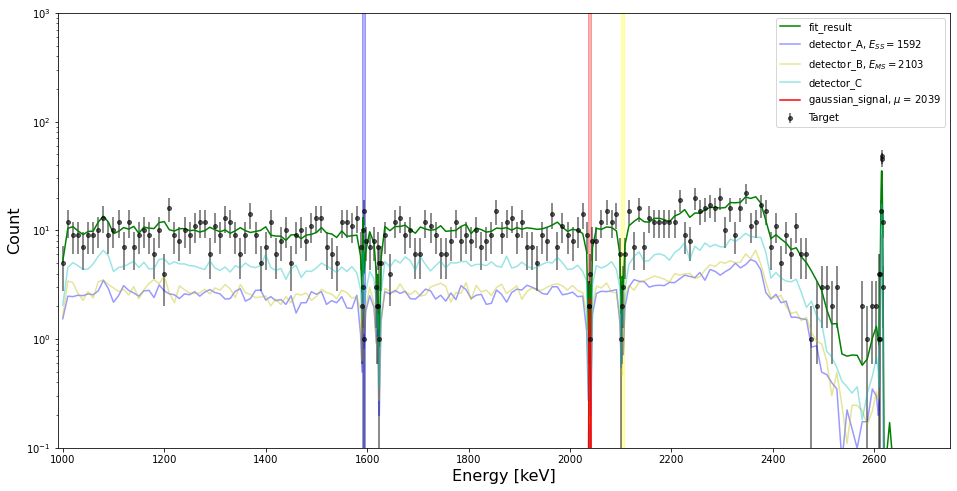

In [465]:
# our observered data or the fitting target:
target, target_edges = np.histogram(detector_Target_cut['Energy'], bins = n_bins, range = (lowE, highE))


def bkg_A(E_min, E_max, n_bins, A):
  bkg_A, A_edges = np.histogram(detectorA_cut['Energy'], bins = n_bins, density = True, range = (lowE, highE))

  bin_centers = (A_edges[:-1] + A_edges[1:]) / 2
  bin_widths = np.diff(A_edges)

  bkgA_integral = np.sum(bkg_A * bin_widths)  # Integral of the bkg over bins
  normalized_bkgA = bkg_A * (A / bkgA_integral)

  # Calculate the bkgA counts in each bin
  bkgA_counts = normalized_bkgA * bin_widths
  return bin_centers, bkgA_counts

def bkg_B(E_min, E_max, n_bins, B):
  bkg_B, B_edges = np.histogram(detectorB_cut['Energy'], bins = n_bins, density = True, range = (lowE, highE))
  bin_centers = (B_edges[:-1] + B_edges[1:]) / 2
  bin_widths = np.diff(B_edges)

  bkgB_integral = np.sum(bkg_B * bin_widths)  # Integral of the bkg over bins
  normalized_bkgB = bkg_B * (B / bkgB_integral)

  # Calculate the bkgB counts in each bin
  bkgB_counts = normalized_bkgB * bin_widths

  return bin_centers, bkgB_counts

def bkg_C(E_min, E_max, n_bins, C):
  bkg_C, C_edges = np.histogram(detectorC_cut['Energy'], bins = n_bins, density = True, range = (lowE, highE))

  bin_centers = (C_edges[:-1] + C_edges[1:]) / 2
  bin_widths = np.diff(C_edges)

  bkgC_integral = np.sum(bkg_C * bin_widths)  # Integral of the bkg over bins
  normalized_bkgC = bkg_C * (C / bkgC_integral)

  # Calculate the bkgC counts in each bin
  bkgC_counts = normalized_bkgC * bin_widths

  return bin_centers, bkgC_counts

def bkg(E_min, E_max, n_bins, A, B, C):

  bin_centers, bkgA = bkg_A(lowE, highE, n_bins, A)
  _, bkgB = bkg_B(lowE, highE, n_bins, B)
  _, bkgC = bkg_C(lowE, highE, n_bins, C)

  return bin_centers, (bkgA + bkgB + bkgC)

def signal(E_min, E_max, n_bins, E_0, sigma, S):
    '''
    Input:
        E_min, E_max: min and max of the energy range
        n_bins: number of bins within the energy range
        B: background event rate, unit: number of events ?
        E_0: the energy of the monoenergetic signal
        sigma: the width of the signal energy spectrum (assuming gaussian)
        S: total number of signal events
    Output:
        bin_centers: array contains the central energy of the energy bins
        signal_counts: array contains the expected number of signals in each energy bin
    '''

    # Define the energy bin edges
    # bin_edges = np.linspace(E_min, E_max, len(n_bins))
    bin_edges = target_edges
    # bin_edges = np.linspace(E_min, E_max, len(n_bins) + 1)

    # Calculate the Gaussian distribution for each bin
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)

    # Gaussian function for each bin,
    # Note that we are interested in only the normalized gaussian,
    # thus the coefficient will be dropped by the divison
    gaussian = np.exp(-0.5 * ((bin_centers - E_0) / sigma) ** 2)

    # Normalize the Gaussian so that the total signal is equal to S
    gaussian_integral = np.sum(gaussian * bin_widths)  # Integral of the Gaussian over bins
    normalized_gaussian = gaussian * (S / gaussian_integral)

    # Calculate the signal counts in each bin
    signal_counts = normalized_gaussian * bin_widths
    # signal_counts = gaussian * bin_widths

    return bin_centers, signal_counts

# define the chi-square function:
def chi2(S_fit, A_fit, B_fit, C_fit):
    epsilon = 1e-6
    _, signal_counts = signal(lowE, highE, n_bins, N_peak, sigma, S_fit)
    # bkg_counts = A_fit * bkg_A + B_fit * bkg_B + C_fit * bkg_C
    _, bkg_counts = bkg(lowE, highE, n_bins, A_fit, B_fit, C_fit)
    E = signal_counts + bkg_counts
    O = target

    # E_zero_indices = np.where(E == 0)
    # E[E_zero_indices] = 1
    # O_zero_indices = np.where(O == 0)
    # O[O_zero_indices] = 1

    E = np.where(E == 0, epsilon, E)
    # O = np.where(O == 0, epsilon, O)

    chi2_value = np.sum((O-E)*(O-E)/E)

    return chi2_value


# Initial guess of the parameters
S_init = 1
A_init = 1000
B_init = 1000
C_init = 1000

minuit = Minuit(chi2, S_fit = S_init, A_fit = A_init, B_fit = B_init, C_fit = C_init)
minuit.limits = [(0, None), (0, None), (0, None), (0, None)]
minuit.migrad()  # Minimization

# Print the fit results
best_fit_S = minuit.values["S_fit"]
best_fit_A = minuit.values["A_fit"]
best_fit_B = minuit.values["B_fit"]
best_fit_C = minuit.values["C_fit"]

best_fit_S_err = minuit.errors["S_fit"]
best_fit_A_err = minuit.errors["A_fit"]
best_fit_B_err = minuit.errors["B_fit"]
best_fit_C_err = minuit.errors["C_fit"]


print(f"Best-fit S: {best_fit_S:.2f}")
print(f"Best-fit A: {best_fit_A:.2f}" + f" \u00B1 {best_fit_A_err:.3f}")
print(f"Best-fit B: {best_fit_B:.2f}" + f" \u00B1 {best_fit_B_err:.3f}")
print(f"Best-fit C: {best_fit_C:.2f}" + f" \u00B1 {best_fit_C_err:.3f}")


# Print the best-fit chi-square value
chi2_min = minuit.fval

print (f"Best-fit chi-square: {chi2_min:.2f}")

plt.figure(figsize=(16,8))
plt.plot(bkg(lowE,highE , n_bins, best_fit_A, best_fit_B, best_fit_C)[0],
         bkg(lowE,highE , n_bins, best_fit_A, best_fit_B, best_fit_C)[1] + signal(lowE, highE, n_bins, N_peak, sigma, best_fit_S)[1],color='g', label='fit_result')
plt.plot(bkg_A(lowE,highE , n_bins, best_fit_A)[0], bkg_A(lowE,highE , n_bins, best_fit_A)[1],alpha=0.4,color='b', label='detector_A, ' + r'$E_{SS} = $' + str(A_peak))
plt.plot(bkg_B(lowE,highE , n_bins, best_fit_B)[0], bkg_B(lowE,highE , n_bins, best_fit_B)[1],alpha=0.4,color='y', label='detector_B, ' + r'$E_{MS} = $' + str(B_peak))
plt.plot(bkg_C(lowE,highE , n_bins, best_fit_C)[0], bkg_C(lowE,highE , n_bins, best_fit_C)[1],alpha=0.4,color='c', label='detector_C')
# plt.hist(detector_Target_cut['Energy'], bins = n_bins, range = (lowE, highE), histtype='step', stacked=True, fill=False, label='fit_target', color='k')
plt.errorbar((target_edges[:-1] + target_edges[1:]) / 2, target, yerr=np.sqrt(target),
             fmt='o', linestyle='None', markersize=4,
             alpha=0.6, color='black', label='Target')
# plt.scatter((target_edges[:-1] + target_edges[1:]) / 2, target
#             , linestyle='None', s=10,
#              alpha=0.6, color='black', label='Target')
plt.plot(signal(lowE, highE, n_bins, N_peak, sigma, best_fit_S)[0],signal(lowE, highE, n_bins, N_peak, sigma, best_fit_S)[1],color='r',label='gaussian_signal, ' + r'$\mu$ = ' + str(N_peak))

plt.fill_between(A_peak_arr, counts_lo, counts_hi, color='blue', alpha=0.3)
plt.fill_between(B_peak_arr, counts_lo, counts_hi, color='yellow', alpha=0.3)
plt.fill_between(N_peak_arr, counts_lo, counts_hi, color='red', alpha=0.3)

plt.yscale('log')
plt.legend()
plt.ylim(1e-1,1e3)
plt.xlim(0.99e3,2.75e3)
# plt.xlim(N_peak_lo,N_peak_hi)

plt.xlabel('Energy [keV]',fontsize=16)
plt.ylabel('Count',fontsize=16)

plt.show()




## Calculation of the upper limit of $θ_{NLDBD}$ at 90% confidence level.


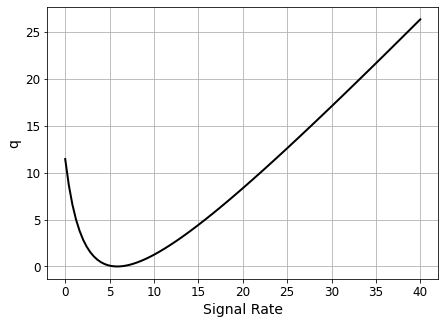

In [466]:
# Array to store q values for different signal strengths
S_scan = np.linspace(0, 40, 100)  # Test range of signal strengths
q_values = []

for s in S_scan:
    # Perform a minimization for each fixed S_scan
    # m_fixed = Minuit(lambda _fit: B_init, S_fit = s)
    m_fixed = Minuit(chi2, S_fit = s, A_fit = A_init, B_fit = B_init, C_fit = C_init)
    m_fixed.fixed["S_fit"] = True
    m_fixed.limits = [(0, None), (0, None), (0, None), (0, None)]
    m_fixed.migrad()
    chi2_fixed = m_fixed.fval

    # Calculate q for this signal rate
    q = chi2_fixed - chi2_min
    q_values.append(q)

# Plot q vs. signal rate
plt.figure(figsize=(7, 5))
plt.plot(S_scan, q_values, color='black', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()

Upper-limit on Signal Rate: 12.53


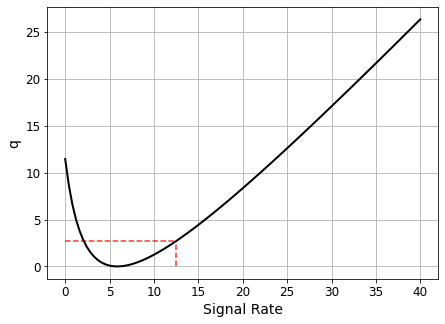

In [467]:
real_closest_diff = float('inf')
real_closest_rate = float('inf')
for i in range(len(S_scan)):
    if abs(q_values[i]-2.71) < real_closest_diff and S_scan[i]>best_fit_S: # Note that the upperlimit has to be greater than S_best-fit
        real_closest_diff = abs(q_values[i]-2.71)
        real_closest_rate = S_scan[i]
print (f"Upper-limit on Signal Rate: {real_closest_rate:.2f}")

# Plot q vs. signal rate and the critial signal rate
plt.figure(figsize=(7, 5))
plt.plot(S_scan, q_values, color='black', linewidth=2)
plt.hlines(2.71, 0, real_closest_rate, linestyle='--', color='red', alpha=0.8)
plt.vlines(real_closest_rate, 0, 2.71, linestyle='--', color='red', alpha=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()

## Calculation of the experimental sensitivity of $θ_{NLDBD}$
*Note that this part will take > 1 hr to run *

***Uncomment the following code to obtain the detector sensitivity to NLDBD***

In [ ]:
# Total number of sensitivity trials to run
N_pts = 1000

In [ ]:
# def generate_toy_mc(E_min, E_max, n_bins, E_0, sigma, S, A, B, C):
#     '''
#     Input:
#         E_min, E_max: min and max of the energy range
#         n_bins: number of bins within the energy range
#         E_0: energy of the monoenergetic signal
#         sigma: width of the signal energy spectrum (assuming Gaussian)
#         S: total number of signal eventss
#         B: total number of background events
#     Output:
#         toy_data: simulated events in each bin, signal_observed + background_observed
#     '''
#     # Implement your code below
#     _, background_counts = bkg(E_min, E_max, n_bins, A, B, C)
#     _, signal_counts = signal(E_min, E_max, n_bins, E_0, sigma, S)


#     observed_signal_counts = np.random.poisson(signal_counts)
#     observed_bkg_counts = np.random.poisson(background_counts)


#     toy_data = observed_signal_counts + observed_bkg_counts
#     return toy_data



# def chi2(S_fit, A_fit, B_fit, C_fit):
#     epsilon = 1e-3
#     _, signal_counts = signal(lowE, highE, n_bins, N_peak, sigma, S_fit)
#     # bkg_counts = A_fit * bkg_A + B_fit * bkg_B + C_fit * bkg_C
#     _, bkg_counts = bkg(lowE, highE, n_bins, A_fit, B_fit, C_fit)
#     E = signal_counts + bkg_counts
#     O = observed_counts

#     # E_zero_indices = np.where(E == 0)
#     # E[E_zero_indices] = 1
#     # O_zero_indices = np.where(O == 0)
#     # O[O_zero_indices] = 1

#     E = np.where(E == 0, epsilon, E)
#     # O = np.where(O == 0, epsilon, O)

#     chi2_value = np.sum((O-E)*(O-E)/E)

#     return chi2_value


# limit_arr = []
# # Initial guess of the parameters
# S_init = best_fit_S
# A_init = best_fit_A
# B_init = best_fit_B
# C_init = best_fit_C

# for i in range(N_pts):

#     observed_counts = generate_toy_mc(lowE, highE, n_bins, N_peak, sigma, best_fit_S, best_fit_A, best_fit_B, best_fit_C)

#     minuit = Minuit(chi2, S_fit = S_init, A_fit = A_init, B_fit = B_init, C_fit = C_init)
#     minuit.limits = [(0, None), (0, None), (0, None), (0, None)]
#     minuit.migrad()  # Minimization

#     # Print the fit results
#     toy_best_fit_S = minuit.values["S_fit"]
#     # toy_best_fit_A = minuit.values["A_fit"]
#     # toy_best_fit_B = minuit.values["B_fit"]
#     # toy_best_fit_C = minuit.values["C_fit"]

#     # print(f"Best-fit S: {best_fit_S:.2f}")
#     # print(f"Best-fit A: {best_fit_A:.2f}")
#     # print(f"Best-fit B: {best_fit_B:.2f}")
#     # print(f"Best-fit C: {best_fit_C:.2f}")

#     # Print the best-fit chi-square value
#     toy_chi2_min = minuit.fval


#     S_scan = np.linspace(0, 40, 100)  # Test range of signal strengths
#     q_values = []

#     for s in S_scan:
#         # Perform a minimization for each fixed S_scan
#         # m_fixed = Minuit(lambda _fit: B_init, S_fit = s)
#         m_fixed = Minuit(chi2, S_fit = s, A_fit = A_init, B_fit = B_init, C_fit = C_init)
#         m_fixed.fixed["S_fit"] = True
#         m_fixed.limits = [(0, None), (0, None), (0, None), (0, None)]
#         m_fixed.migrad()
#         chi2_fixed = m_fixed.fval

#         # Calculate q for this signal rate
#         q = chi2_fixed - toy_chi2_min
#         q_values.append(q)


#     closest_diff = float('inf')
#     closest_rate = float('inf')
#     for i in range(len(S_scan)):
#         if abs(q_values[i]-2.71) < closest_diff and S_scan[i]>toy_best_fit_S: # Note that the upperlimit has to be greater than S_best-fit
#             closest_diff = abs(q_values[i]-2.71)
#             closest_rate = S_scan[i]

#     limit_arr.append(closest_rate)





## Calculation of the sensitivity of $θ_{NLDBD} $ using fitting on $θ_{NLDBD}$ only...


In [469]:
# Number of total trial wish to iteral through....
N_trials = 200

In [470]:
def generate_toy_mc(E_min, E_max, n_bins, E_0, sigma, S, A, B, C):
    '''
    Input:
        E_min, E_max: min and max of the energy range
        n_bins: number of bins within the energy range
        E_0: energy of the monoenergetic signal
        sigma: width of the signal energy spectrum (assuming Gaussian)
        S: total number of signal eventss
        B: total number of background events
    Output:
        toy_data: simulated events in each bin, signal_observed + background_observed
    '''
    # Implement your code below
    _, background_counts = bkg(E_min, E_max, n_bins, A, B, C)
    _, signal_counts = signal(E_min, E_max, n_bins, E_0, sigma, S)


    observed_signal_counts = np.random.poisson(signal_counts)
    observed_bkg_counts = np.random.poisson(background_counts)


    toy_data = observed_signal_counts + observed_bkg_counts
    return toy_data



def chi2(S_fit, A_fit, B_fit, C_fit):
    epsilon = 1e-3
    _, signal_counts = signal(lowE, highE, n_bins, N_peak, sigma, S_fit)
    # bkg_counts = A_fit * bkg_A + B_fit * bkg_B + C_fit * bkg_C
    _, bkg_counts = bkg(lowE, highE, n_bins, A_fit, B_fit, C_fit)
    E = signal_counts + bkg_counts
    O = observed_counts

    # E_zero_indices = np.where(E == 0)
    # E[E_zero_indices] = 1
    # O_zero_indices = np.where(O == 0)
    # O[O_zero_indices] = 1

    E = np.where(E == 0, epsilon, E)
    # O = np.where(O == 0, epsilon, O)

    chi2_value = np.sum((O-E)*(O-E)/E)

    return chi2_value


limit_arr = []
# Initial guess of the parameters
S_init = best_fit_S
A_init = best_fit_A
B_init = best_fit_B
C_init = best_fit_C

for i in range(N_trials):

    observed_counts = generate_toy_mc(lowE, highE, n_bins, N_peak, sigma, best_fit_S, best_fit_A, best_fit_B, best_fit_C)

    minuit = Minuit(chi2, S_fit = S_init, A_fit = A_init, B_fit = B_init, C_fit = C_init)
    minuit.limits = [(0, None), (0, None), (0, None), (0, None)]
    minuit.migrad()  # Minimization

    # Print the fit results
    toy_best_fit_S = minuit.values["S_fit"]
    # toy_best_fit_A = minuit.values["A_fit"]
    # toy_best_fit_B = minuit.values["B_fit"]
    # toy_best_fit_C = minuit.values["C_fit"]

    # print(f"Best-fit S: {best_fit_S:.2f}")
    # print(f"Best-fit A: {best_fit_A:.2f}")
    # print(f"Best-fit B: {best_fit_B:.2f}")
    # print(f"Best-fit C: {best_fit_C:.2f}")

    # Print the best-fit chi-square value
    toy_chi2_min = minuit.fval


    limit_arr.append(toy_best_fit_S)





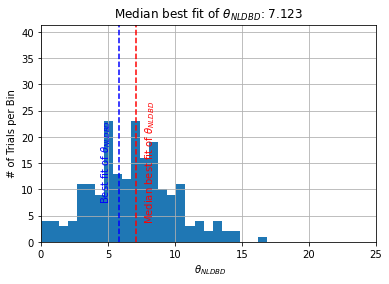

In [475]:
limit_median = np.median(limit_arr)

limit_bins, limit_edges,_ = plt.hist(limit_arr,bins=25)
plt.vlines(limit_median,limit_bins.min(),limit_bins.max()+20,colors='r',linestyles='--')
plt.vlines(best_fit_S,limit_bins.min(),limit_bins.max()+20,colors='b',linestyle='--')
plt.ylim(limit_bins.min(),limit_bins.max()*1.8)
plt.xlim(0,25)
plt.title(r'Median best fit of $\theta_{NLDBD}$: ' + str(np.round(limit_median,3)))
plt.xlabel(r' $\theta_{NLDBD}$')
plt.ylabel('# of Trials per Bin')
plt.text(limit_median + 1, max(limit_arr)/1.1, r'Median best fit of $\theta_{NLDBD}$', horizontalalignment='center',
     verticalalignment='center',c='r',rotation=90)
plt.text(best_fit_S - 1, max(limit_arr)/1.1, r'Best fit of $\theta_{NLDBD}$', horizontalalignment='center',
     verticalalignment='center',c='b',rotation=90)
plt.grid()     
plt.show()

In [ ]:
time.sleep(2)  # Example of some operation
end = time.time()
print(f"Running time: {end - start:.4f} seconds")


Running time: 35501.2036 seconds
